In [2]:
import os
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

# Can We Make Coherent Categories of Different Food.com Recipe Names?

### Introduction to Food.com and our goals
Food.com is an online website that people share their recipes on. This results in a diverse mix of different dishes, desserts, and cuisines. We're wondering if we can find any sort of semantic "category" or groups that exist within the titles of these different recipes. Instead of working on all 180k+ recipe names in the Food.com Recipes and Interactions Kaggle dataset, however, for simplicity we are going to work just with a sample.

 We get this by taking recipes without names, with duplicate names, and with names that are too short (less than or equal to 5 characters long) out of our dataset, and selecting only the top recipes.

In [3]:
orig_recipes_df = pd.read_csv(
    "data/RAW_recipes.csv",
    engine="python", on_bad_lines='skip')
orig_recipes_df.shape

(6555, 12)

In [4]:
def get_recipes_sample(orig_recipes_df, n_tags=300, min_len=5):
    orig_recipes_df = orig_recipes_df.dropna()  # Remove rows with NaNs.
    orig_recipes_df = orig_recipes_df.drop_duplicates(
        "name"
    )  # Remove rows with duplicate names.
    # Remove rows where recipe names are too short (< 5 characters).
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len]
    # Only consider the rows where tags are one of the most frequent n tags.
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist()
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

recipes_df = get_recipes_sample(orig_recipes_df)
recipes_df.shape

(470, 12)

This results in a new dataset that has 470 columns (470 recipes) and 12 rows.

### Data Understanding and Exploratory Data Analysis (EDA) ###

Different features/aspects of the different recipes are as follows:

- name: name of the recipe
- id: Food.com recipe ID
- minutes: how long the recipe takes to make
- contributor_id: the ID of the person who uploaded the recipe
- submitted: the date that the recipe was submitted
- tags: the tags that the recipe falls under
- nutrition: nutrional information of the recipe
- n_steps: the total number of steps in the recipe
- steps: the actual steps of how to make the recipe
- description: the description of the recipe
- ingredients: the ingredients required to make the recipe
- n_ingredients: the number of ingrediants needed to make the recipe




We are going to just use the **name** feature, as our goal is to try to see if we can create distinct categories. (For the rest of this project, I'm going to just use the subset of the dataset we made earlier.)

We can try to gleam some more information about the data we have through some Exploratory Data Analysis. I did some other EDA outside of this report which helped me learn more about the names and the dataset in general. I made this word cloud to visualize some of the most common words in the names of the dataset:

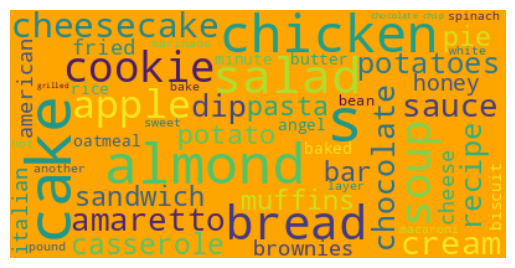

In [ ]:
from wordcloud import WordCloud

names = recipes_df['name'].astype('string')

text = names.str.cat(sep = " ")
wordcloud = WordCloud(max_font_size = 50, max_words = 50, background_color = "orange").generate(text)

plt.plot()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

This word cloud shows us some of the most common words we've found in the recipe names. The larger words are ones that appear more frequently and more prominently in the photo, meaning that "amaretto" is the most popular in this dataset.

### Trying To Group The Recipe Names

In order to get a good representation of the names, we need to embed them. This means we need to encode the text into numberical vectors that will preserve the semantic meaning. We are going to use the embedded names for the rest of this project.

In [11]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = embedder.encode(names.tolist())
embeddings_df = pd.DataFrame(embeddings, index=recipes_df.index)
embeddings_df

ModuleNotFoundError: Could not import module 'CodeCarbonCallback'. Are this object's requirements defined correctly?

Before we can get to actually clustering the names into groups, we need to figure out what the best model to use is, and what settings/hyperparameters to apply to those models. One way we can try this is by graphing out different visuals for different settings in a specific model, and seeing which settings perform best on each model. I did this behind the scenes and I resulted in relatively similar results for all the models I chose.

I've decided to use the K-Means model as my final model for this clustering task because of its simplicity. To make sure I'm choosing the right settings (also known as hyperparamter) for this model, I charted out this graph:

![download.png](attachment:a68c4926-ff6c-4077-9263-2ee59088c726.png)

Even after trying different values, I just ended up using the point with the dashed vertical line. In this case, the dashed vertical line is at 3, so I set the graph's hyperparameter to 3, which gives me the following groups of recipe names:

![download.png](attachment:6bcff5ca-fe1e-4dd2-a3b3-c4850914cbd7.png)